In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from multiLevelCoSurrogates.config import data_dir


funcset = {
    '2d': ['bohachevsky', 'branin', 'booth', 'himmelblau', 'sixHumpCamelBack'],
    '4d': ['park91a', 'park91b'],
    '8d': ['borehole'],
}

In [2]:
df = pd.read_csv('{}timing_summary.csv'.format(data_dir), index_col=0)
df.head()

,function,surrogate,usage,repetition,gen_int,lambda_pre,time
0,bohachevsky,Kriging,reg,0,1,2,2.465569
1,bohachevsky,Kriging,reg,0,2,2,975.813294
2,bohachevsky,Kriging,reg,0,3,2,151.718057
3,bohachevsky,Kriging,reg,0,5,2,6.719542
4,bohachevsky,Kriging,reg,0,10,2,23.358003


In [3]:
df.groupby(by=['function', 'surrogate', 'usage', 'gen_int'])['time'].mean()

function          surrogate     usage      gen_int
bohachevsky       Kriging       reg        1            6.315216
                                           2          402.690602
                                           3           89.306009
                                           5           25.631838
                                           10          16.144881
                                scaled-MF  1            3.670082
                                           2           38.697520
                                           3          155.163241
                                           5           27.625730
                                           10          26.880650
                  NoSurrogate   reg        0            0.066830
                  RBF           reg        1           25.267990
                                           2          138.806736
                                           3           15.389102
                                       

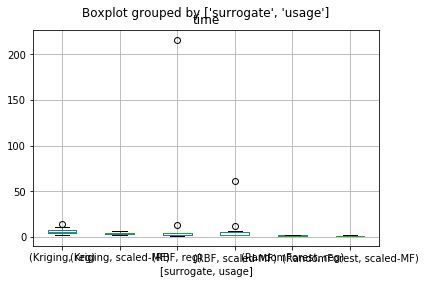

In [4]:
df[(df['function']=='bohachevsky') & (df['gen_int']==1)].boxplot(column='time', by=['surrogate', 'usage'])    

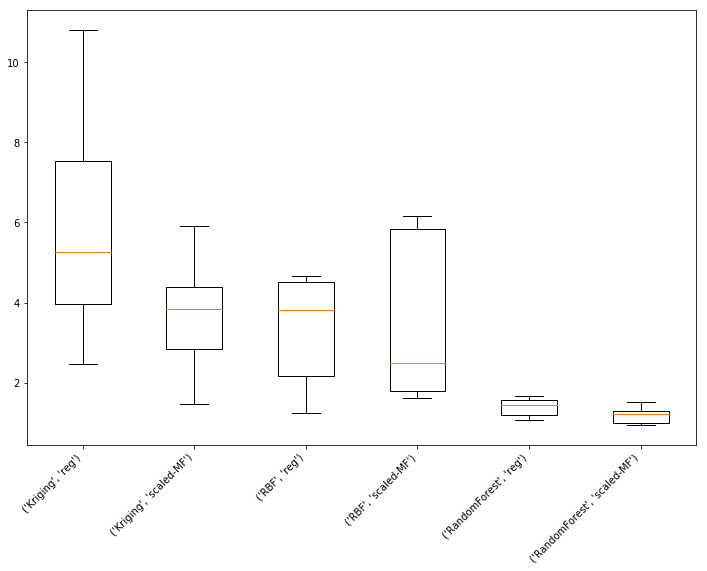

In [5]:
sub_df = df[(df['function']=='bohachevsky') & (df['gen_int']==1)]
labels, data = zip(*[(key, values['time']) for key, values in sub_df.groupby(by=['surrogate', 'usage'])])

plt.figure(figsize=(12,8))
plt.boxplot(data, sym='')
plt.xticks(np.arange(len(labels))+1, labels, rotation=45, horizontalalignment='right')
plt.show()

/scratch/python/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]


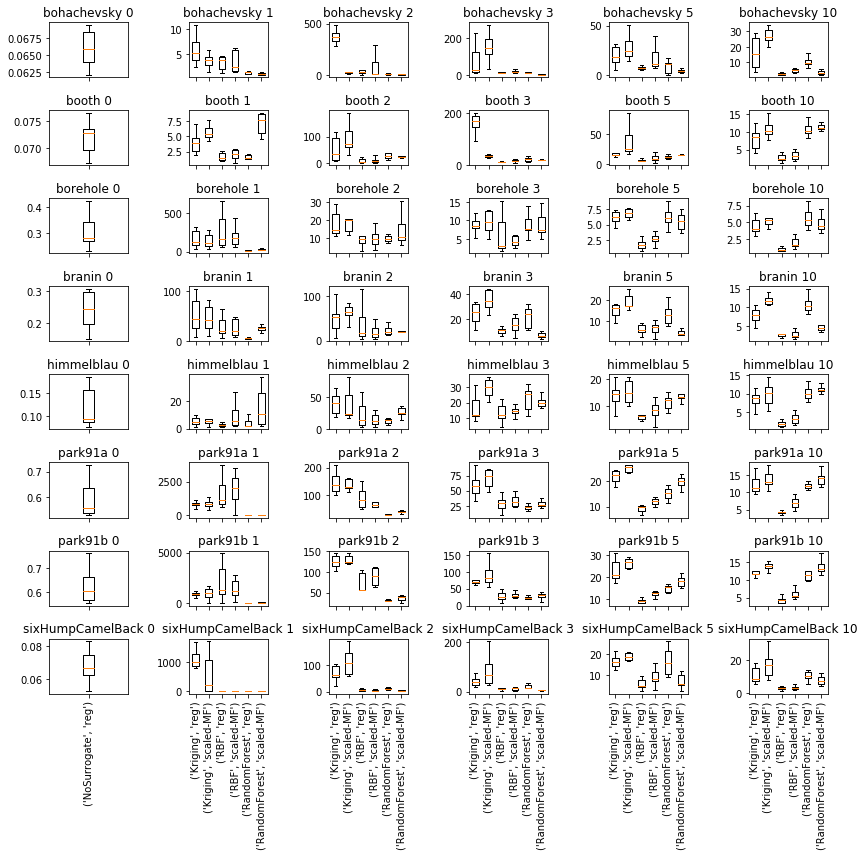

In [6]:
def boxplot_per_func_genint(df):
    """This function creates a grid of boxplots: one for each function-generation interval combination.
    """

    num_funcs = len(df['function'].unique())
    num_gen_ints = len(df['gen_int'].unique())

    plt.figure(figsize=(12,12))
    idx = 0
    for func, func_df in df.groupby(by=['function']):
        for gen_int, gen_int_df in func_df.groupby(by=['gen_int']):
            idx += 1
            sub_df = gen_int_df[(gen_int_df['function']==func) & (df['gen_int']==gen_int)]
            labels, data = zip(*[(key, values['time']) for key, values in sub_df.groupby(by=['surrogate', 'usage'])])
            plt.subplot(num_funcs, num_gen_ints, idx)
            plt.boxplot(data, sym='')  # sym='' means we ignore outliers
            plt.title(func + ' ' + str(gen_int))
            
            # Only add the full labels on the bottom row, remove on the other rows
            if idx > (num_funcs-1)*num_gen_ints:
                plt.xticks(np.arange(len(labels))+1, labels, rotation=90)
            else:
                plt.xticks(np.arange(len(labels))+1, [''] * len(labels))

    plt.tight_layout()
    plt.show()
    
boxplot_per_func_genint(df)

In [7]:
def scale_per_func_genint(df):
    """Creates a copy of the DataFrame whereby all runtime values are scaled relative to the mean runtime
    of the fastest method for each function/generational interval combination.
    These relative speeds allow aggregation in later plots/functions.
    """

    all_scaled = df.copy(deep=True)

    for func, func_df in all_scaled.groupby(by=['function']):
        for gen_int, gen_int_df in func_df.groupby(by=['gen_int']):
            sub_df = gen_int_df[(gen_int_df['function']==func) & (df['gen_int']==gen_int)]

            argmin_idx = sub_df.groupby(by=['surrogate', 'usage'])['time'].mean().argmin()
            argmin_data = sub_df[(sub_df['surrogate']==argmin_idx[0]) & (sub_df['usage']==argmin_idx[1])]['time']
            mean, std = argmin_data.mean(), argmin_data.std()
            sub_df['time'] = sub_df['time'] / mean
            all_scaled.update(sub_df)
            
    return all_scaled

all_scaled = scale_per_func_genint(df)

/scratch/python/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/scratch/python/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  del sys.path[0]


In [8]:
all_scaled.head()

,function,surrogate,usage,repetition,gen_int,lambda_pre,time
0,bohachevsky,Kriging,reg,0.0,1.0,2.0,2.085335
1,bohachevsky,Kriging,reg,0.0,2.0,2.0,192.288733
2,bohachevsky,Kriging,reg,0.0,3.0,2.0,25.089932
3,bohachevsky,Kriging,reg,0.0,5.0,2.0,1.550591
4,bohachevsky,Kriging,reg,0.0,10.0,2.0,8.056739


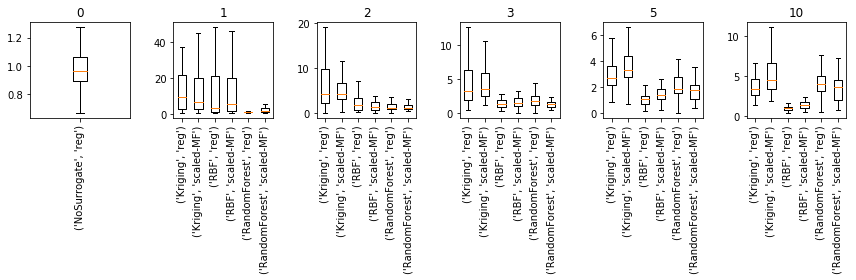

In [9]:
def boxplot_per_genint(df):
    """Create boxplots that are aggregated over all functions. Only different generation intervals
    are compared in the different plots here. Assumes scaling/normalization is already done by the caller.
    """

    num_gen_ints = len(df['gen_int'].unique())

    plt.figure(figsize=(12,4))
    idx = 0
    for gen_int, gen_int_df in df.groupby(by=['gen_int']):
        idx += 1
        sub_df = gen_int_df[(gen_int_df['gen_int']==gen_int)]
        labels, data = zip(*[(key, values['time']) for key, values in sub_df.groupby(by=['surrogate', 'usage'])])
        plt.subplot(1, num_gen_ints, idx)
        plt.boxplot(data, sym='', labels=labels)
        plt.title(str(int(gen_int)))
        plt.xticks(np.arange(len(labels))+1, labels, rotation=90)

    plt.tight_layout()
    plt.show()
    
boxplot_per_genint(all_scaled)

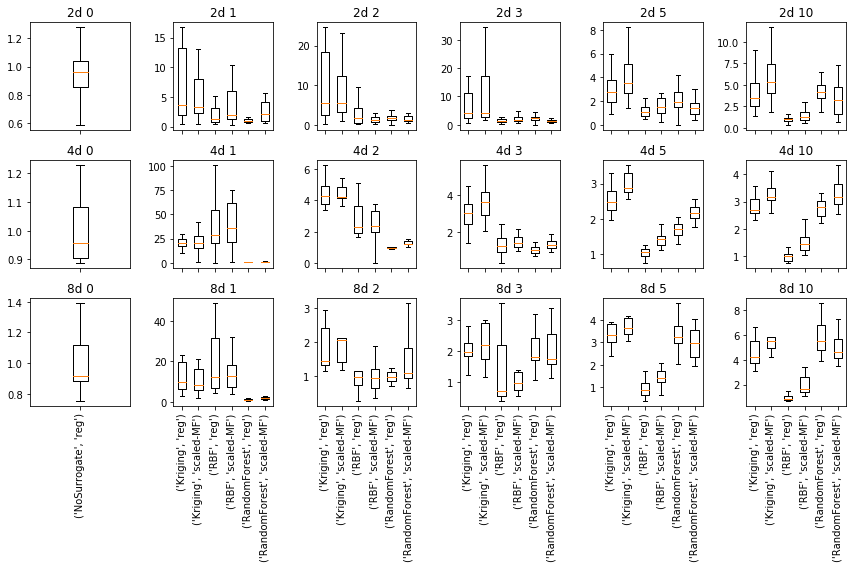

In [10]:
def boxplot_per_funcset_genint(df, funcset):
    """Create boxplots that are aggregated over the given sets of functions.
    Assumes scaling/normalization is already done by the caller.
    """

    num_func_sets = len(funcset.keys())
    num_gen_ints = len(df['gen_int'].unique())

    plt.figure(figsize=(12,8))
    idx = 0
    for func_set_name, func_set in funcset.items():
        func_df = df[df['function'].isin(func_set)]

        for gen_int, gen_int_df in func_df.groupby(by=['gen_int']):
            idx += 1
            sub_df = gen_int_df[gen_int_df['gen_int']==gen_int]
            labels, data = zip(*[(key, values['time']) for key, values in sub_df.groupby(by=['surrogate', 'usage'])])
            plt.subplot(num_func_sets, num_gen_ints, idx)
            plt.boxplot(data, sym='')
            plt.title(func_set_name + ' ' + str(int(gen_int)))
            if idx > (num_func_sets-1)*num_gen_ints:
                plt.xticks(np.arange(len(labels))+1, labels, rotation=90)
            else:
                plt.xticks(np.arange(len(labels))+1, [''] * len(labels))

    plt.tight_layout()
    plt.show()
    
boxplot_per_funcset_genint(all_scaled, funcset)

In [11]:
def add_nosurrogate_per_genint(df):
    """Currently, the 'NoSurrogate' surrogate type is stored under generational interval 0,
    as there is no generational interval to speak of.
    To easily use it as a comparison for the other methods, we now add the data per function
    multiple times, once for each generational interval.
    """

    no_surrogate = df.copy(deep=True)
    gen_ints = set(df['gen_int'].unique()) - {0}
    no_surr = df[df['gen_int'] == 0]
    
    for func, func_df in no_surr.groupby(by=['function']):
        for gen_int in gen_ints:
            func_df['gen_int'] = gen_int
            no_surrogate = no_surrogate.append(func_df, ignore_index=True)
    
    # Finally, we remove the original gen_int == 0 rows
    no_surrogate = no_surrogate[no_surrogate['gen_int'] != 0]
    return no_surrogate

no_surrogate = add_nosurrogate_per_genint(df)
print(no_surrogate[no_surrogate['surrogate']=='NoSurrogate'].head())

/scratch/python/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


         function    surrogate usage  repetition  gen_int  lambda_pre  \
2479  bohachevsky  NoSurrogate   reg           1        1           0   
2480  bohachevsky  NoSurrogate   reg           2        1           0   
2481  bohachevsky  NoSurrogate   reg           3        1           0   
2482  bohachevsky  NoSurrogate   reg           4        1           0   
2483  bohachevsky  NoSurrogate   reg           5        1           0   

          time  
2479  0.062922  
2480  0.075862  
2481  0.063995  
2482  0.068360  
2483  0.062094  


/scratch/python/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


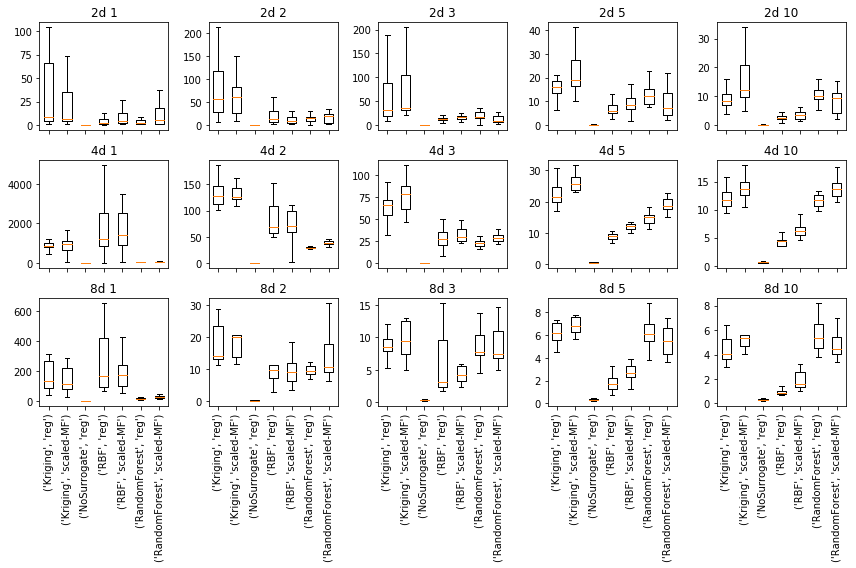

In [12]:
# And now with everything scaled according to the 'NoSurrogate' runtime
boxplot_per_funcset_genint(no_surrogate, funcset)